# Computing velocities through lines parallel to the cut

## Load data and modules

In [40]:
# !{sys.executable} -m pip install import-ipynb

In [41]:
# Load modules
import tqdm
import czifile
import tifffile
import sys
import os
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib

from PIL import Image
from IPython.display import Image as IPImage, display
from matplotlib.animation import FuncAnimation
from skimage.io import imread

import cv2


In [42]:
# Convert images to tiff
src_folder = '../../data/ablation-czi'
new_folder = '../../data/tiff'

# Create new folder
os.makedirs(new_folder, exist_ok=True)

# Check if destination folder already has files
if len(os.listdir(new_folder)) > 0:
    print(f"Folder {new_folder} already has files — skipping conversion.")
else:
    # Convert all .czi files
    for file in tqdm.tqdm(os.listdir(src_folder), desc="Converting CZI to TIFF"):
        if file.endswith('.czi'):
            czi_path = os.path.join(src_folder, file)
            out_path = os.path.join(new_folder, file.replace('.czi', '.tiff'))

            with czifile.CziFile(czi_path) as czi:
                img = czi.asarray()
                tifffile.imwrite(out_path, img)

    print("Conversion complete!")

Folder ../../data/tiff already has files — skipping conversion.


## Retrieve images

In [43]:
experiment = '220530-E1_Out'

In [44]:
# Reading in the image from the associated experiment

image_dir = '../../data/tiff'
image_files = [f for f in os.listdir(image_dir) if experiment in f and f.endswith('.tiff')] # type: ignore
if len(image_files) > 1:
    raise ValueError(f'Expected only one image for experiment {experiment}, but found {len(image_files)}')

image = tifffile.TiffFile(f'{image_dir}/{image_files[0]}')
image_data = np.squeeze(image.asarray())

In [45]:
# Preparation for visual plotting
channel_red     = image_data[0] # shape -> (115, 512, 512)
channel_green   = image_data[1] # shape -> (115, 512, 512)

# Normalize for visualization 
channel_red_norm    = channel_red / channel_red.max()
channel_green_norm  = channel_green / channel_green.max()

# Create RG(B) stack for each slice
rgb_stack = np.zeros((115, 512, 512, 1), dtype=np.float32)
rgb_stack[..., 0] = channel_red_norm
#rgb_stack[..., 1] = channel_green_norm

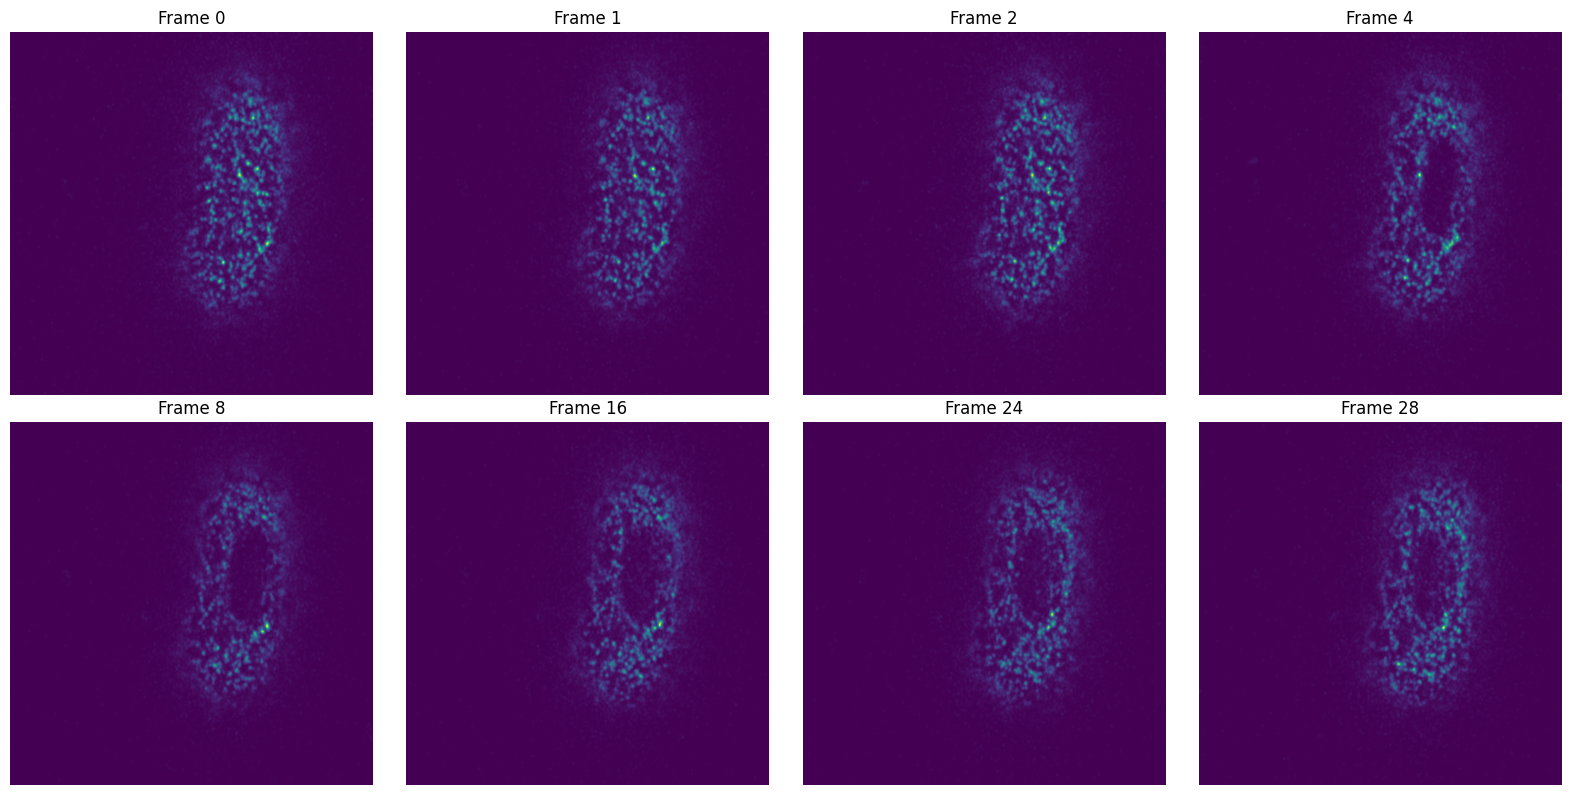

In [49]:
def visualize_frames_grid(rgb_stack: np.ndarray, frames: list[int]):
    n_frames = len(frames)
    cols = 4
    rows = (n_frames + cols - 1) // cols  # ceiling division

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = np.array(axes).reshape(rows, cols)

    for i, frame_idx in enumerate(frames):
        r, c = divmod(i, cols)
        axes[r, c].imshow(rgb_stack[frame_idx])
        axes[r, c].set_title(f"Frame {frame_idx}")
        axes[r, c].axis('off')

    # Hide any unused subplots
    for j in range(i + 1, rows * cols):
        r, c = divmod(j, cols)
        axes[r, c].axis('off')

    plt.tight_layout()
    plt.show()

visualize_frames_grid(rgb_stack, [0, 1, 2, 4, 8, 16, 24, 28])

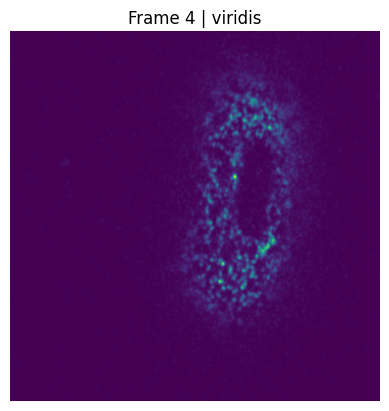

In [68]:
def visualize_frame(rgb_stack: np.ndarray, frame_idx: int, channel: int = 0, cmap: str = 'viridis', ax=None):

    frame = rgb_stack[frame_idx, :, :, channel]

    if ax is None:
        fig, ax = plt.subplots()

    im = ax.imshow(frame, cmap=cmap)
    ax.set_title(f"Frame {frame_idx} | {cmap}")
    ax.axis('off')
    return ax

img = visualize_frame(rgb_stack, 4)
plt.show()

## Visualize cut

In [ ]:
# Get points for experiment
cell_id_to_keep = experiment

# Load the data
points_file_loc = f"../../data/ablation-lineage/{cell_id_to_keep}.lineage"
df = pd.read_csv(points_file_loc, sep='\t')

df.head()

# Extract cuts
df_cuts = df[df.iloc[:, 0].str.contains("cut", case=False, na=False)]

df_cuts.head()

,cell,time,x,y,z,radius,self,parent,child1,child2
9,cut2,4,333.0,262.0,0.0,9.625,2,-1,-1,-1
11,cut1,4,342.0,169.0,0.0,9.625,4,-1,-1,-1


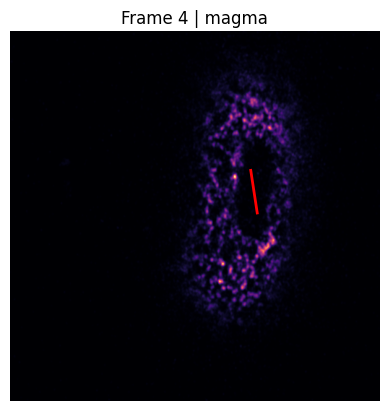

In [128]:
### --- Draw cut line --- ###

# Extract the points for the cuts (first two rows in this case)
x1, y1 = df_cuts.iloc[0]['x'], df.iloc[0]['y']
x2, y2 = df_cuts.iloc[1]['x'], df.iloc[1]['y']

img = visualize_frame(rgb_stack, 4, cmap='magma')
img.plot([x1, x2], [y1, y2], color='red', linewidth=2)
plt.show()


## Trash for now

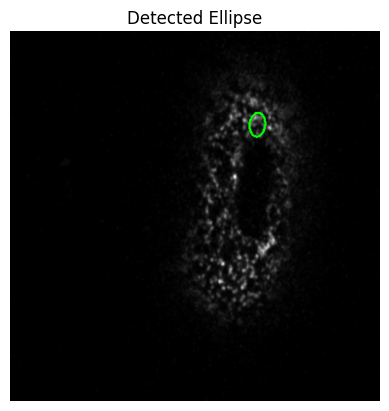

In [100]:
### --- Detect cut --- ###

frame = rgb_stack[4, :, :, 0]  # same frame index & channel as before

# Convert to 8-bit grayscale (if not already)
frame_uint8 = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Run your ellipse detection code on `frame_uint8`
img_norm = cv2.normalize(frame_uint8, None, 0, 255, cv2.NORM_MINMAX)
#img_norm = cv2.bitwise_not(img_norm)
blur = cv2.GaussianBlur(img_norm, (3, 3), 0)
edges = cv2.Canny(blur, 10, 300)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
output = cv2.cvtColor(frame_uint8, cv2.COLOR_GRAY2BGR)

if contours:
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for c in contours:
        if len(c) >= 5:
            ellipse = cv2.fitEllipse(c)
            cv2.ellipse(output, ellipse, (0, 255, 0), 2)
            break

plt.imshow(output[..., ::-1])
plt.title("Detected Ellipse")
plt.axis('off')
plt.show()

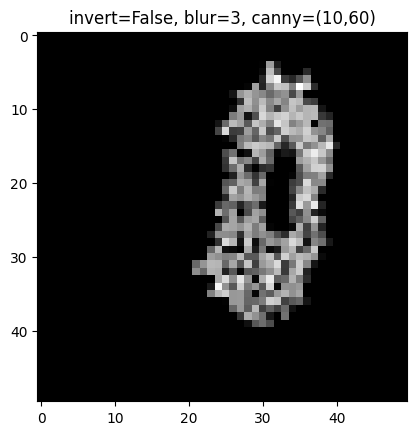

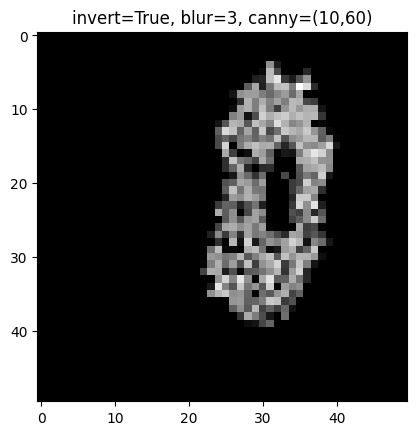

[[0.6133464  0.6133464  0.6133464  ... 0.6133464  0.61328506 0.61328506]
 [0.6133464  0.6133464  0.6133464  ... 0.6133464  0.6133464  0.6133464 ]
 [0.6133464  0.6133464  0.61328506 ... 0.6133464  0.6133464  0.61340773]
 ...
 [0.61340773 0.61359173 0.61365306 ... 0.61346906 0.6135304  0.6133464 ]
 [0.61346906 0.61389846 0.6140211  ... 0.6135304  0.6135304  0.61340773]
 [0.6135304  0.6139598  0.61408246 ... 0.61346906 0.6135304  0.61340773]]


In [124]:
# Get the actual image frame (a NumPy array)
frame = rgb_stack[4, :, :, 0]  # for example: frame 4, channel 0

# Convert to uint8 for OpenCV if needed
frame_uint8 = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)



# Now you can safely process it
for invert in [False, True]:
    for blur_k in [3]:
        for low, high in [(10, 60)]:
            proc = cv2.bitwise_not(frame_uint8) if invert else frame_uint8  # valid NumPy array
            blur = cv2.GaussianBlur(proc, (blur_k, blur_k), 0)
            edges = cv2.Canny(blur, low, high)
            area = cv2.resize(edges, (50, 50), interpolation=cv2.INTER_AREA)
            blur = cv2.GaussianBlur(proc, (blur_k, blur_k), 0)
            plt.imshow(area, cmap='gray')
            plt.title(f'invert={invert}, blur={blur_k}, canny=({low},{high})')
            plt.show()

print(frame)



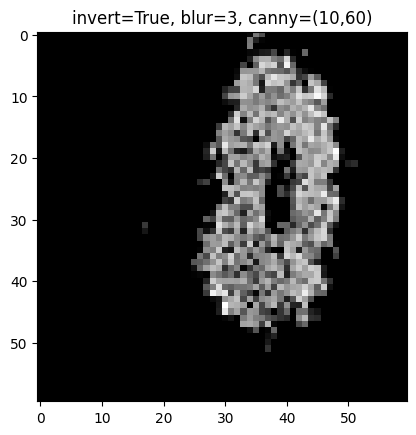

[[0.6133464  0.6133464  0.6133464  ... 0.6133464  0.61328506 0.61328506]
 [0.6133464  0.6133464  0.6133464  ... 0.6133464  0.6133464  0.6133464 ]
 [0.6133464  0.6133464  0.61328506 ... 0.6133464  0.6133464  0.61340773]
 ...
 [0.61340773 0.61359173 0.61365306 ... 0.61346906 0.6135304  0.6133464 ]
 [0.61346906 0.61389846 0.6140211  ... 0.6135304  0.6135304  0.61340773]
 [0.6135304  0.6139598  0.61408246 ... 0.61346906 0.6135304  0.61340773]]


In [125]:
# Blur
# Get the actual image frame (a NumPy array)
frame = rgb_stack[4, :, :, 0]  # for example: frame 4, channel 0

# Convert to uint8 for OpenCV if needed
img = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)



# Now you can safely process it
#for invert in [False, True]:
    #for blur_k in [3]:
        #for low, high in [(10, 60)]:
edges = cv2.Canny(img, 10, 50)
area = cv2.resize(edges, (60, 60), interpolation=cv2.INTER_AREA)
blur = cv2.GaussianBlur(area, (3, 3), 0)
plt.imshow(area, cmap='gray')
plt.title(f'invert={invert}, blur={blur_k}, canny=({low},{high})')
plt.show()

print(frame)


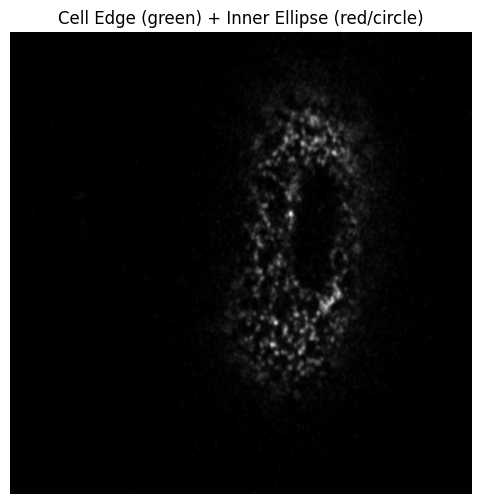

In [106]:
# --- Get frame (already in your code)
frame = rgb_stack[4, :, :, 0]
frame_uint8 = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# --- Preprocess
proc = frame_uint8  # not inverted (you can try cv2.bitwise_not for comparison)
blur = cv2.GaussianBlur(proc, (5, 5), 0)
edges = cv2.Canny(blur, 10, 60)

# --- Find contours *with hierarchy*
contours, hierarchy = cv2.findContours(edges, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# --- Draw everything for inspection
output = cv2.cvtColor(frame_uint8, cv2.COLOR_GRAY2BGR)

outer_contours = []
inner_contours = []

if hierarchy is not None:
    hierarchy = hierarchy[0]  # flatten hierarchy array
    for i, (cnt, hier) in enumerate(zip(contours, hierarchy)):
        area = cv2.contourArea(cnt)
        if area < 200:  # ignore very small specks
            continue

        # hierarchy info: [next, previous, first_child, parent]
        parent = hier[3]

        if parent == -1:
            # No parent → outer contour (cell edge)
            outer_contours.append(cnt)
        else:
            # Has a parent → inner contour (hole)
            inner_contours.append(cnt)

# --- Draw results
# Outer boundary in green
cv2.drawContours(output, outer_contours, -1, (0, 255, 0), 2)

# Inner (ellipse-like) contours in red
cv2.drawContours(output, inner_contours, -1, (255, 0, 0), 2)

# --- Optionally fit ellipse to largest inner contour
if len(inner_contours) > 0:
    inner_contours = sorted(inner_contours, key=cv2.contourArea, reverse=True)
    c = inner_contours[0]
    if len(c) >= 5:
        ellipse = cv2.fitEllipse(c)
        cv2.ellipse(output, ellipse, (0, 0, 255), 2)

        # Also draw enclosing circle (optional)
        (center, axes, angle) = ellipse
        radius = int(max(axes) / 2)
        cv2.circle(output, (int(center[0]), int(center[1])), radius, (255, 255, 0), 2)

# --- Show result
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Cell Edge (green) + Inner Ellipse (red/circle)")
plt.axis('off')
plt.show()


## Blur image

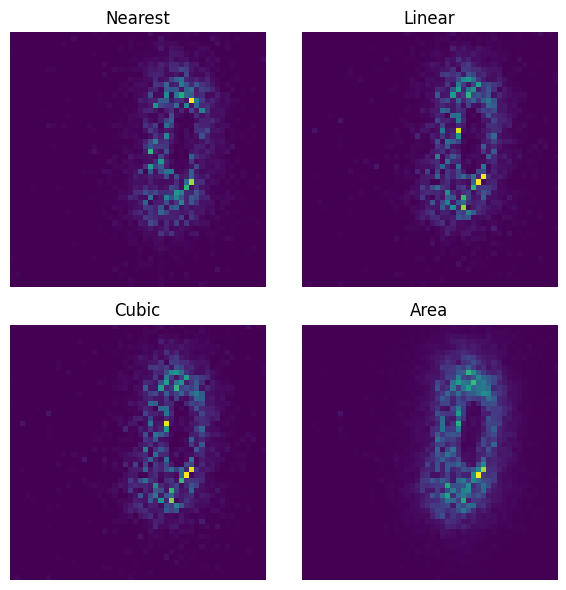

In [185]:
# Differences in interpolation in OpenCV

# Resize using different interpolation methods
small_nearest = cv2.resize(img, (50, 50), interpolation=cv2.INTER_NEAREST)
small_linear  = cv2.resize(img, (50, 50), interpolation=cv2.INTER_LINEAR)
small_cubic   = cv2.resize(img, (50, 50), interpolation=cv2.INTER_CUBIC)
small_area    = cv2.resize(img, (50, 50), interpolation=cv2.INTER_AREA)

# Plot all interpolation results together
plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1); plt.imshow(small_nearest); plt.title("Nearest"); plt.axis('off')
plt.subplot(2, 2, 2); plt.imshow(small_linear); plt.title("Linear"); plt.axis('off')
plt.subplot(2, 2, 3); plt.imshow(small_cubic); plt.title("Cubic"); plt.axis('off')
plt.subplot(2, 2, 4); plt.imshow(small_area); plt.title("Area"); plt.axis('off')
plt.tight_layout()
plt.show()

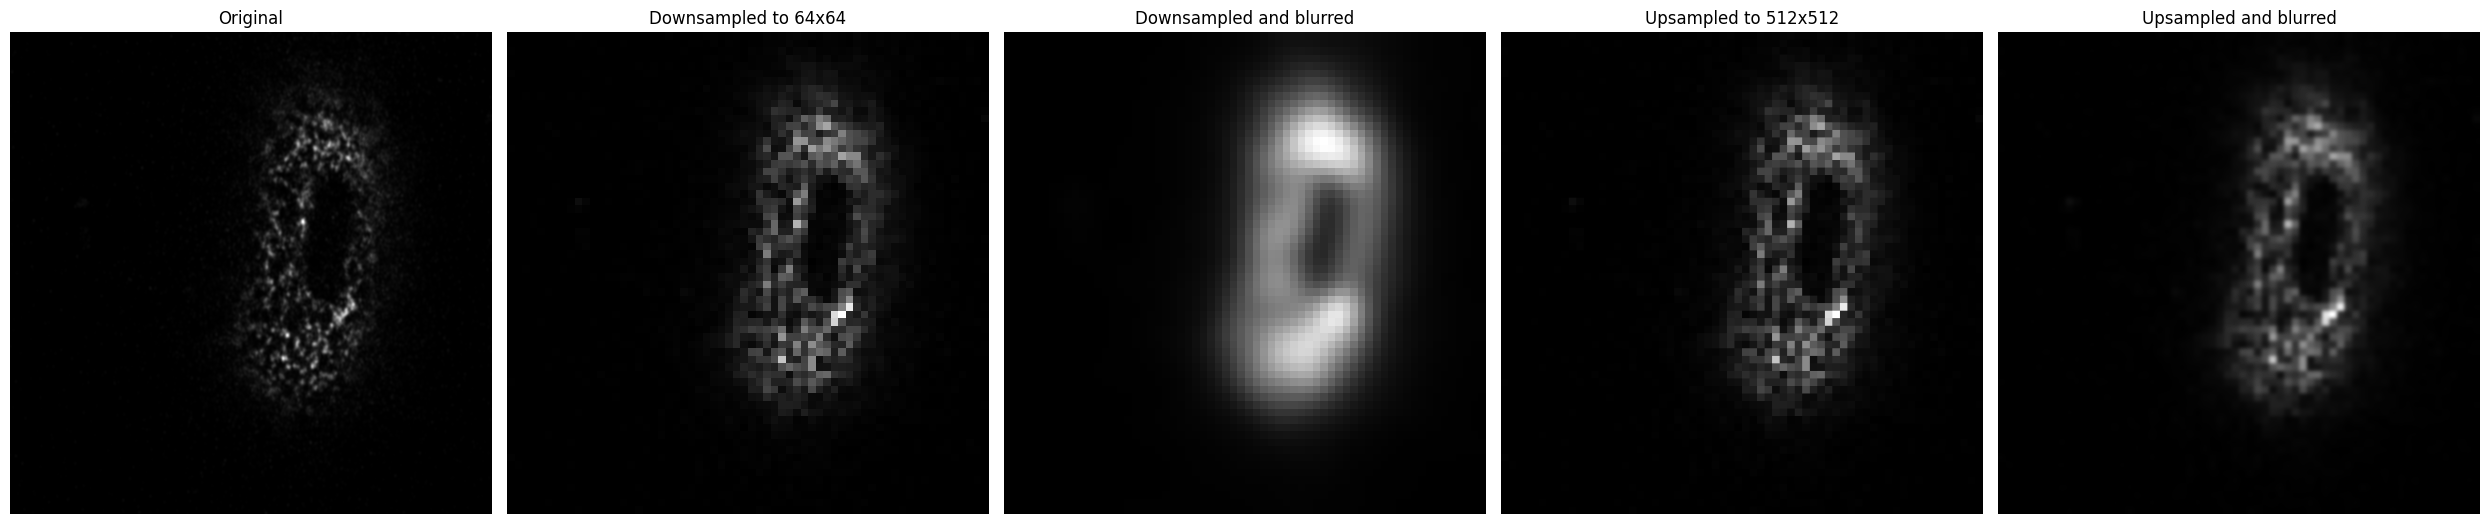

In [ ]:
# Downsampling, upsampling, then blur

img = rgb_stack[4, :, :, 0] # first col is frame

interpolation_method = cv2.INTER_AREA # cv2.INTER_CUBIC, cv2.INTER_LINEAR, cv2.INTER_NEAREST

downsampled = cv2.resize(img, (64, 64), interpolation=interpolation_method)
upsampled = cv2.resize(downsampled, (512, 512), interpolation=interpolation_method)
downsampled_blurred = cv2.GaussianBlur(downsampled, (31,31), 2)
upsampled_blurred = cv2.GaussianBlur(upsampled, (31,31), 2)

plt.figure(figsize=(25,6))
plt.subplot(1,5,1); plt.imshow(img, cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(1,5,2); plt.imshow(downsampled, cmap='gray'); plt.title('Downsampled to 64x64'); plt.axis('off')
plt.subplot(1,5,3); plt.imshow(downsampled_blurred, cmap='gray'); plt.title('Downsampled and blurred'); plt.axis('off')
plt.subplot(1,5,4); plt.imshow(upsampled, cmap='gray'); plt.title('Upsampled to 512x512'); plt.axis('off')
plt.subplot(1,5,5); plt.imshow(upsampled_blurred, cmap='gray'); plt.title('Upsampled and blurred'); plt.axis('off')
plt.tight_layout()
plt.show()

Upsampled:
[[0.00240527 0.00240527 0.00240527 ... 0.00240618 0.00240618 0.00240618]
 [0.00240527 0.00240527 0.00240527 ... 0.00240618 0.00240618 0.00240618]
 [0.00240527 0.00240527 0.00240527 ... 0.00240618 0.00240618 0.00240618]
 ...
 [0.00240559 0.00240559 0.00240559 ... 0.00240541 0.00240542 0.00240542]
 [0.00240559 0.00240559 0.00240559 ... 0.00240541 0.00240542 0.00240542]
 [0.00240559 0.00240559 0.00240559 ... 0.00240541 0.00240542 0.00240542]]
Mean: 0.002423363272100687, SD: 3.929359445464797e-05
Downsampled:
{img_float2}
Mean: 0.0024233651347458363, SD: 3.2042658858699724e-05


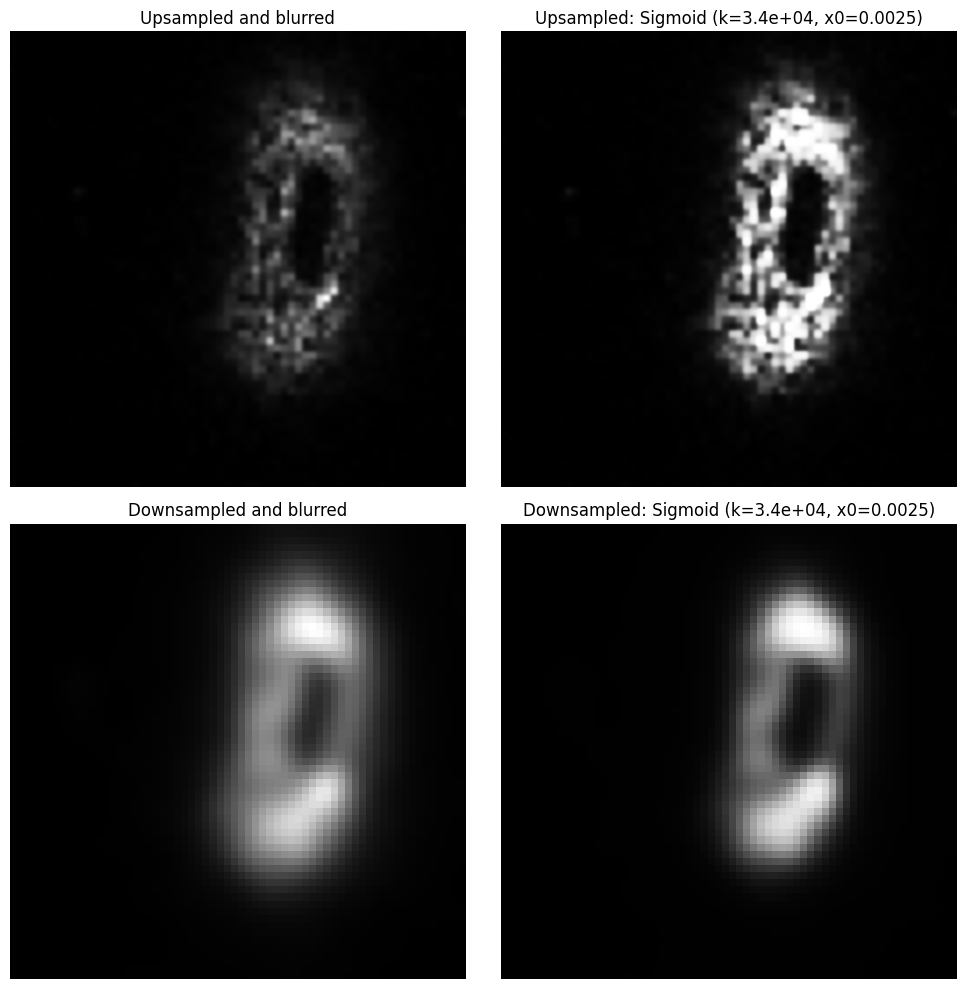

In [215]:
### --- Sigmoid contrast adjustment --- ###

## Upsampled
img_ub = upsampled_blurred

# Convert to float and normalize (0–1)
img_float = img_ub.astype(np.float32) / 255.0
print(f"Upsampled:\n{img_float}")
mean, sd = np.mean(img_float), np.std(img_float)
print(f"Mean: {mean}, SD: {sd}")

# Sigmoid parameters (centered near mean, tuned for narrow SD)
x0 = mean + 1.5 * sd   # shift midpoint right → darker output
k = 3.4e4   # steepness (adjust as needed)

# Apply sigmoid with clipping for stability
arg = np.clip(k * (img_float - x0), -60, 60)
sigmoid = 1 / (1 + np.exp(-arg))

# Convert back to 8-bit
sigmoid_img = np.uint8(sigmoid * 255)


## Downsampled
img_db = downsampled_blurred

# Convert to float and normalize (0–1)
img_float2 = img_db.astype(np.float32) / 255.0
print("Downsampled:\n{img_float2}")
mean2, sd2 = np.mean(img_float2), np.std(img_float2)
print(f"Mean: {mean2}, SD: {sd2}")

# Sigmoid parameters (centered near mean, tuned for narrow SD)
x02 = mean2 + 2.5 * sd2   # shift midpoint right → darker output
k2 = 3.4e4   # steepness (adjust as needed)

# Apply sigmoid with clipping for stability
arg2 = np.clip(k2 * (img_float2 - x02), -60, 60)
sigmoid2 = 1 / (1 + np.exp(-arg2))

# Convert back to 8-bit
sigmoid_img2 = np.uint8(sigmoid2 * 255)



# Display comparison
plt.figure(figsize=(10,10))
plt.subplot(2,2,1); plt.imshow(img_float, cmap='gray'); plt.title('Upsampled and blurred'); plt.axis('off')
plt.subplot(2,2,2); plt.imshow(sigmoid_img, cmap='gray'); plt.title(f'Upsampled: Sigmoid (k={k:.1e}, x0={x0:.4f})'); plt.axis('off')
plt.subplot(2,2,3); plt.imshow(img_float2, cmap='gray'); plt.title('Downsampled and blurred'); plt.axis('off')
plt.subplot(2,2,4); plt.imshow(sigmoid_img2, cmap='gray'); plt.title(f'Downsampled: Sigmoid (k={k2:.1e}, x0={x02:.4f})'); plt.axis('off')
plt.tight_layout()
plt.show()


## Annotate frame with points

In [176]:
# Points csv
cell_id_to_keep = "220914-E4_Out"

# Load the data
points_file_loc = f"../../data/ablation-lineage/{cell_id_to_keep}.lineage"
df2 = pd.read_csv(points_file_loc, sep='\t')

df2.head()

# Extract cuts
df_cuts2 = df2[df2.iloc[:, 0].str.contains("cut", case=False, na=False)]

df_cuts2.head()


,cell,time,x,y,z,radius,self,parent,child1,child2
20,cut1,4,213.0,172.0,0.0,9.625,6,-1,-1,-1
24,cut2,4,319.0,278.0,0.0,9.625,10,-1,-1,-1
